In [1]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random
%matplotlib inline

In [2]:
# Load names
names = []
with open('names.txt') as f:
    names = f.readlines()
names = [ x.strip() for x in names]
names

['emma',
 'olivia',
 'ava',
 'isabella',
 'sophia',
 'charlotte',
 'mia',
 'amelia',
 'harper',
 'evelyn',
 'abigail',
 'emily',
 'elizabeth',
 'mila',
 'ella',
 'avery',
 'sofia',
 'camila',
 'aria',
 'scarlett',
 'victoria',
 'madison',
 'luna',
 'grace',
 'chloe',
 'penelope',
 'layla',
 'riley',
 'zoey',
 'nora',
 'lily',
 'eleanor',
 'hannah',
 'lillian',
 'addison',
 'aubrey',
 'ellie',
 'stella',
 'natalie',
 'zoe',
 'leah',
 'hazel',
 'violet',
 'aurora',
 'savannah',
 'audrey',
 'brooklyn',
 'bella',
 'claire',
 'skylar',
 'lucy',
 'paisley',
 'everly',
 'anna',
 'caroline',
 'nova',
 'genesis',
 'emilia',
 'kennedy',
 'samantha',
 'maya',
 'willow',
 'kinsley',
 'naomi',
 'aaliyah',
 'elena',
 'sarah',
 'ariana',
 'allison',
 'gabriella',
 'alice',
 'madelyn',
 'cora',
 'ruby',
 'eva',
 'serenity',
 'autumn',
 'adeline',
 'hailey',
 'gianna',
 'valentina',
 'isla',
 'eliana',
 'quinn',
 'nevaeh',
 'ivy',
 'sadie',
 'piper',
 'lydia',
 'alexa',
 'josephine',
 'emery',
 'julia'

In [3]:
# create mapping from letters to indices
letters = []
for name in names:
    letters.extend(list(name))
letters.extend('.')
letters = list(set(letters))
letters.sort()
mapping = dict(zip(letters, list(range(27))))
mapping

{'.': 0,
 'a': 1,
 'b': 2,
 'c': 3,
 'd': 4,
 'e': 5,
 'f': 6,
 'g': 7,
 'h': 8,
 'i': 9,
 'j': 10,
 'k': 11,
 'l': 12,
 'm': 13,
 'n': 14,
 'o': 15,
 'p': 16,
 'q': 17,
 'r': 18,
 's': 19,
 't': 20,
 'u': 21,
 'v': 22,
 'w': 23,
 'x': 24,
 'y': 25,
 'z': 26}

In [4]:
# split names into training, dev / validation and test
random.seed(42)
random.shuffle(names)
n1 = int(0.8 * len(names))
n2 = int(0.9 * len(names))
names_trn = names[0:n1]
names_dev = names[n1:n2]
names_tst = names[n2:]
print(f"Training {len(names_trn)} Dev/Validation {len(names_dev)} Testing {len(names_tst)}")

Training 25626 Dev/Validation 3203 Testing 3204


In [5]:
# create n-grams & datasets

ngram_bucket_size = 4

def create_ngrams(names_list, bucket_size=ngram_bucket_size):
    ngrams = []
    for name in names_list:
        temp_name = '.'*(bucket_size-1) + name + '.'
        name_ngrams = [ temp_name[i:i+bucket_size] for i in range(0, len(temp_name)-bucket_size+1) ]
        ngrams.extend(name_ngrams)
    return ngrams

def create_dataset_from_ngrams(ngrams):
    X_arr = [ [ mapping[c] for c in ngram[:-1] ] for ngram in ngrams ]
    Y_arr = [ mapping[ngram[-1]] for ngram in ngrams ]
    X = F.one_hot(torch.tensor(X_arr), num_classes=27).to(torch.float32)
    Y = torch.tensor(Y_arr)
    return (X, Y)

def create_dataset_from_names_list(names_list):
    ngrams = create_ngrams(names_list)
    return create_dataset_from_ngrams(ngrams)

X_trn, Y_trn = create_dataset_from_names_list(names_trn)
print(f"X_trn shape: {X_trn.shape}, Y_trn shape: {Y_trn.shape}")
X_dev, Y_dev = create_dataset_from_names_list(names_dev)
print(f"X_dev shape: {X_dev.shape}, Y_dev shape: {Y_dev.shape}")
X_tst, Y_tst = create_dataset_from_names_list(names_tst)
print(f"X_tst shape: {X_tst.shape}, Y_tst shape: {Y_tst.shape}")

X_trn shape: torch.Size([182625, 3, 27]), Y_trn shape: torch.Size([182625])
X_dev shape: torch.Size([22655, 3, 27]), Y_dev shape: torch.Size([22655])
X_tst shape: torch.Size([22866, 3, 27]), Y_tst shape: torch.Size([22866])


In [6]:
# define and initialize parameters
embedding_vec_size = 10
g = torch.Generator().manual_seed(2147483647) # for reproducibility
embedding_W = torch.randn((27, embedding_vec_size), generator=g)
hidden_W = torch.randn(((ngram_bucket_size-1)*embedding_vec_size, 200), generator=g) * \
(5.0/3.0) * (1/((ngram_bucket_size-1)*embedding_vec_size)**0.5) # Kaiming init for tanh activation
hidden_B = torch.randn(200, generator=g) * 0.0
output_W = torch.randn((200, 27), generator=g) * 0.01
output_B = torch.randn(27, generator=g) * 0.0
#output_W = torch.full((200, 27), 1.0)
#output_B = torch.full((27,), 1.0)
parameters = [ embedding_W, hidden_W, hidden_B, output_W, output_B ]
for p in parameters:
    p.requires_grad = True

In [7]:
sum(p.nelement() for p in parameters)

11897

In [8]:
lres = torch.linspace(-3, 0, 1000)
lrs = 10**lres

In [9]:
lossi = []
stepi = []

In [10]:
for i in range(200000):
    # get training batch
    batch_idxs = torch.randint(0, X_trn.shape[0], (32,))
    X_batch = X_trn[batch_idxs]
    Y_batch = Y_trn[batch_idxs]
    
    # forward pass
    embeddings = X_batch @ embedding_W
    embeddings_reshaped = embeddings.view(-1, (ngram_bucket_size-1)*embedding_vec_size)
    hidden_linear = embeddings_reshaped @ hidden_W + hidden_B
    hidden_tanh = hidden_linear.tanh()
    output = hidden_tanh @ output_W + output_B # logits

    # negative log loss
    loss = F.cross_entropy(output, Y_batch)
    #print(f"Iteration: {i}, Loss: {loss.item()}")

    # backprop
    for parameter in parameters:
        parameter.grad = None
    loss.backward()
    
    # update
    lr = 0.1 if i < 100000 else 0.01
    for parameter in parameters:
        parameter.data += -lr * parameter.grad
        
    # track stats
    lossi.append(loss.log10().item())
    stepi.append(i)

Mean: 0.005183056462556124 Stddev: 0.8135448694229126


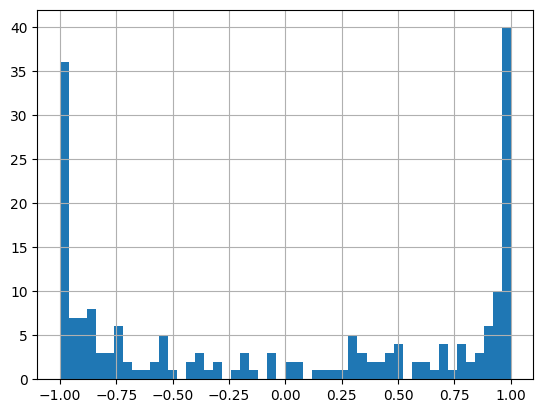

In [27]:
print(f"Mean: {hidden_tanh.view(-1).mean()} Stddev: {hidden_tanh.view(-1).std()}")
plt.hist(hidden_tanh.view(-1).tolist(), bins=50);
plt.grid()

In [12]:
(1 / 30 ** 0.5) * (5/3)

0.3042903097250923

Mean: 0.07901565730571747 Stddev: 2.0104987621307373


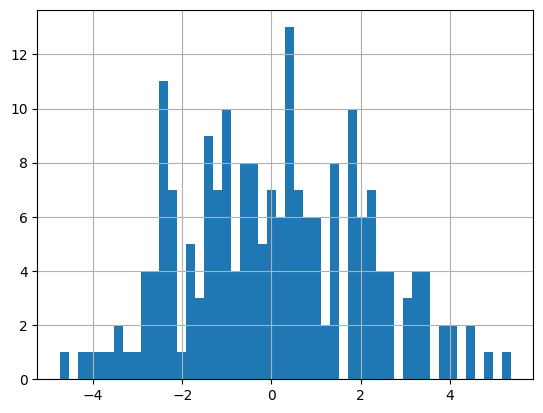

In [26]:
print(f"Mean: {hidden_linear.view(-1).mean()} Stddev: {hidden_linear.view(-1).std()}")
plt.hist(hidden_linear.view(-1).tolist(), bins=50);
plt.grid()

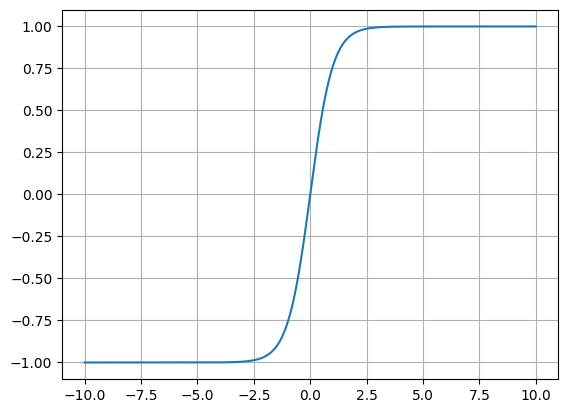

In [24]:
import math
x = np.arange(-10, 10, 0.01)
y = [math.tanh(i) for i in x]
plt.plot(x, y)
plt.grid()

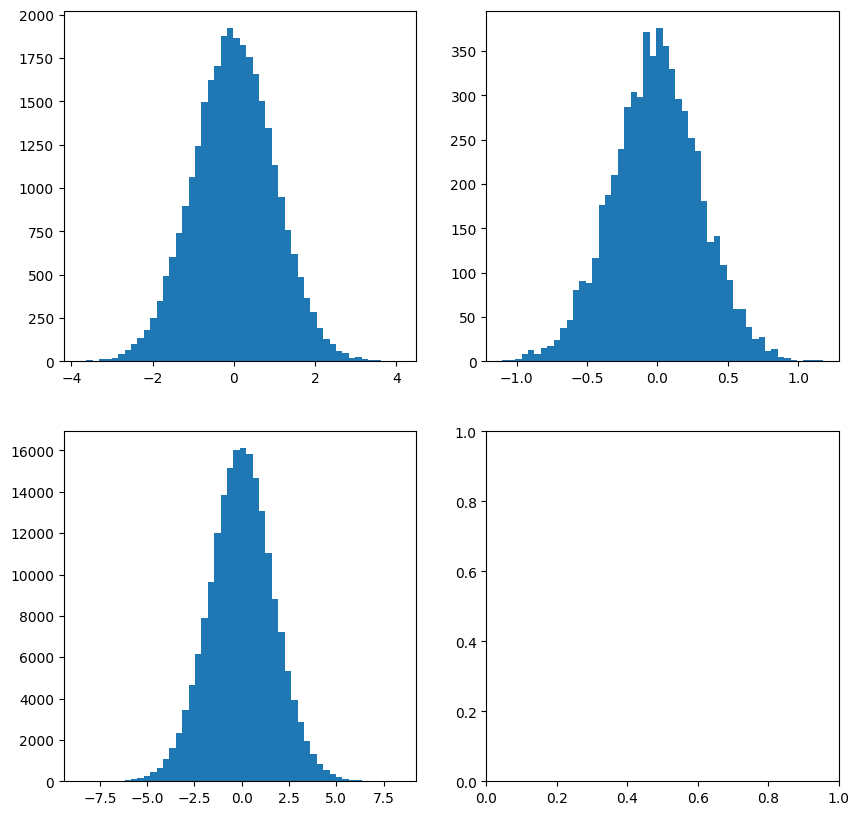

In [15]:
a = torch.randn((1000, 30))
b = torch.randn((30, 200)) * (5/3) * (1/30**0.5)
c = a @ b
fig, ax = plt.subplots(2, 2, figsize=(10, 10))
ax[0, 0].hist(a.view(-1).tolist(), bins=50)
ax[0, 1].hist(b.view(-1).tolist(), bins=50)
ax[1, 0].hist(c.view(-1).tolist(), bins=50)

# Show the figure
plt.show()

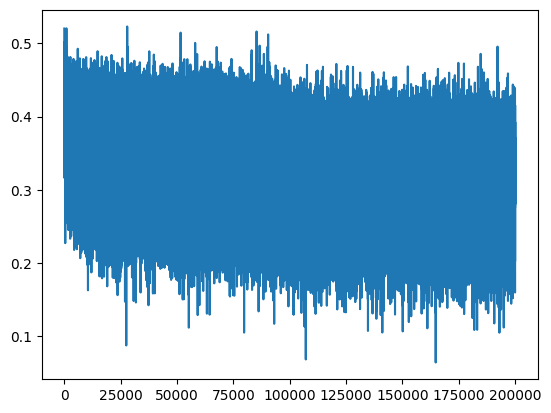

In [16]:
plt.plot(stepi, lossi)

In [17]:
# Calculate loss on all training data
# forward pass
embeddings = X_trn @ embedding_W
embeddings_reshaped = embeddings.view(-1, (ngram_bucket_size-1)*embedding_vec_size)
hidden_linear = embeddings_reshaped @ hidden_W + hidden_B
hidden_tanh = hidden_linear.tanh()
output = hidden_tanh @ output_W + output_B # logits

# negative log loss
loss = F.cross_entropy(output, Y_trn)
print(f"Loss: {loss.item()}")

Loss: 2.038512945175171


In [18]:
# Calculate loss on all dev data
# forward pass
embeddings = X_dev @ embedding_W
embeddings_reshaped = embeddings.view(-1, (ngram_bucket_size-1)*embedding_vec_size)
hidden_linear = embeddings_reshaped @ hidden_W + hidden_B
hidden_tanh = hidden_linear.tanh()
output = hidden_tanh @ output_W + output_B # logits

# negative log loss
loss = F.cross_entropy(output, Y_dev)
print(f"Loss: {loss.item()}")

Loss: 2.1073296070098877


In [19]:
# Calculate loss on all test data
# forward pass
embeddings = X_tst @ embedding_W
embeddings_reshaped = embeddings.view(-1, (ngram_bucket_size-1)*embedding_vec_size)
hidden_linear = embeddings_reshaped @ hidden_W + hidden_B
hidden_tanh = hidden_linear.tanh()
output = hidden_tanh @ output_W + output_B # logits

# negative log loss
loss = F.cross_entropy(output, Y_tst)
print(f"Loss: {loss.item()}")

Loss: 2.103403329849243


In [20]:
# Sample from NN
for i in range(10):
    x_idxs = [0] * (ngram_bucket_size-1)
    char_idxs = [ 0, ]
    while True:
        # forward pass
        x = F.one_hot(torch.tensor(x_idxs), num_classes=27).to(torch.float32)
        embeddings = x @ embedding_W
        embeddings_reshaped = embeddings.view(-1, (ngram_bucket_size-1)*embedding_vec_size)
        hidden_linear = embeddings_reshaped @ hidden_W + hidden_B
        hidden_tanh = hidden_linear.tanh()
        output = hidden_tanh @ output_W + output_B # logits
        
        # create output prob dist
        probs = F.softmax(output, dim=1)
        
        # sample from output prob dist
        next_char = torch.multinomial(probs[0, :], 1, replacement=True).item()
        char_idxs.append(next_char)
        if next_char == 0:
            break
            
        # update input for next iter with next_char
        x_idxs.append(next_char)
        x_idxs = x_idxs[1:]
        
    name_pred = ''.join([letters[idx] for idx in char_idxs])
    print(name_pred)


.madaleillyssah.
.neus.
.sas.
.izley.
.jen.
.arlynn.
.aly.
.lucatali.
.jaharr.
.niz.


In [21]:
-torch.log(torch.tensor(1.0/27.0))

tensor(3.2958)